#  Description

Data Source: [Kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJMW_hourly.csv)

### EnerNed Hourly Energy Consumption Data Scenario

EnerNed is a regional transmission organization in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system in various states.

The company noticed that sometimes it is hard for them to assume what the future demand for power will be. They would like to have a predictive model that would help them in being ready for the increase in demand as well as regulating the transmission in the system once the demand is lower. They would like to also understand how the trends are shaped over time.

The hourly power consumption data comes from EnerNed's website and are in megawatts (MW). Follow the steps below to create a time series model. Please fill the code in the cells where indicated. Don’t worry about the time. If you don’t manage to finish all the exercises, you can always do it at home and compare your answers with the solutions provided in our repository.

Good luck!


# Dependencies

In [3]:
# run just once and then comment it out
%pip install pycaret[full]

In [4]:
import pandas as pd
from pycaret.regression import *
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import matplotlib.pyplot as plt


# Read Raw Data

Our first step is loading the data. Then we are going to do some initial operations like changing the datatypes, sorting it and setting the index.

In [5]:
raw_data = pd.read_csv("PJMW_hourly.csv").copy()

In [6]:
# Show top 10 rows of th dataset
raw_data.head(10)

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
5,2002-12-31 06:00:00,5126.0
6,2002-12-31 07:00:00,5493.0
7,2002-12-31 08:00:00,5824.0
8,2002-12-31 09:00:00,5962.0
9,2002-12-31 10:00:00,6019.0


Code below saves names of the date and target columns. It will facilitate the next steps.

In [7]:
date_col = "Datetime"
target = "PJMW_MW"

Transform columns to appropriate data types. 
Use the following [link](https://www.geeksforgeeks.org/change-data-type-for-one-or-more-columns-in-pandas-dataframe/) in case you are stuck.

In [8]:
# Make the date column datetime type 
raw_data[date_col] = pd.to_datetime(raw_data[date_col])

# Make the target column "float32"
raw_data[target] = raw_data[target].astype(float)

Sort Dataframe and set index. Use the following [link](https://www.geeksforgeeks.org/how-to-sort-pandas-dataframe/) & [link](https://www.geeksforgeeks.org/python-pandas-dataframe-set_index/) in case you are stuck.

In [9]:
# Sort values by the date column
raw_data = raw_data.sort_values(by=date_col)

# Set the date columns as an index
raw_data = raw_data.set_index(date_col)

# Feature Engineering

__ALWAYS THINK OF THE PROBLEM BEFORE CREATING FEATURES!__

In this case, we need to predict hourly consumption of energy for 1 year ahead. Therefore, we will not be able to create features such as lag_1_day, lag_2_months and so forth. Instead, we must create features such as lag_1_year, lag_14_months and so forth. Always think of data availability. You cannot create lag/rolling features in the future, except for those that go back at least for the same time frame as the forecasting horizon, in this case 1 year.

Something that can be done is to incorporate other features such as GDP, PCI and so forth, but when we are forecasting out of sample, therefore when we are forecasting the future, we will need the __forecasts for those features__, because obviously we will not have them at the origin time when creating the future forecast.

Note that it is stil possible to use lag and rolling windows features that have a shorter time frame than the forecasting horizon, but this will mean that we will train a model with say 10 features, but at the origin we will make forecasts using only 5 features, excluding lags and rolling windows. This can have several implications:

- __Out-of-Sample Performance__: The model's performance on the test data (and potentially on out-of-sample data within the testing period) might be reasonably accurate due to the availability of lag and rolling window features during evaluation. However, this performance doesn't guarantee how well the model will generalize to future periods when those features cannot be created.
- __Potential Performance Drop-off__: The model's performance may degrade when forecasting into the future without the lag and rolling window features. This is because the model has learned to rely on those specific features to make predictions, and without them, it might struggle to capture certain patterns or trends.
- __Reduced Feature Space__: In the real-world scenario, if you cannot create lag and rolling window features, you'll be limited to using only the features available at that time (e.g., the 5 features you mentioned). This means the model might not have access to all the information it was trained on, which can limit its forecasting accuracy.

In [10]:
# Create a copy of the original dataframe
fe_data = raw_data.copy()

Create a simple features function and then apply it on our dataset. Use the following [link](https://www.geeksforgeeks.org/python-datetime-datetime-class/) & [link](https://www.geeksforgeeks.org/isocalendar-function-of-datetime-date-class-in-python/) in case you are stuck.

In [11]:
def extract_dt(df):
    """
    Extracts several datetime objects from a datetime index.
    """
    df['hour'] = df.index.hour                           
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month           # Month
    df['year'] = df.index.year          # Year 
    df['dayofyear'] = df.index.dayofyear   # Day of the year
    df['dayofmonth'] = df.index.day      # Day of the month
    df['weekofyear'] =  df.index.isocalendar().week # Week of the year based on the isocalendaryear

    return df

In [12]:
# Run the function to create the dataset (input df = fe_data)

fe_data = extract_dt(fe_data)

Plot the data.

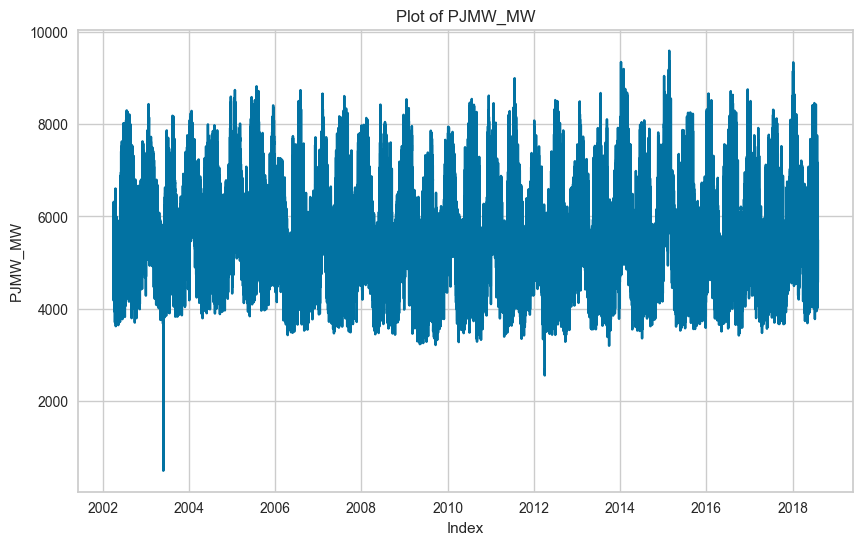

In [13]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(fe_data['PJMW_MW'])
plt.xlabel('Index')
plt.ylabel('PJMW_MW')
plt.title('Plot of PJMW_MW')
plt.grid(True)
plt.show()

We could already train and test a model with only these features, as they can be available in the future, because they simply extract datetime information from dates. Instead we are going to add lags as well.

In [14]:
def add_lags(df, target, lags_dict):
    """
    Creates a mapping between index and target that is used to create lags based on
    a dictionary of lag keys and values.
    """
    target_map = df[target].to_dict()
    for lag, lag_days in lags_dict.items():
        df[f'lag_{lag}_year'] = (df.index - pd.Timedelta(lag_days)).map(target_map)
    
    return df

In [15]:
lags_dict = {
    1: "364 days",
    2: "728 days",
    3: "1092 days"
}

fe_data = add_lags(fe_data, target, lags_dict)

Now we need to remove the index, otherwise pycaret will complain. Use the following [link](https://www.w3schools.com/python/pandas/ref_df_reset_index.asp) in case you are stuck.

In [16]:
# Drop the index of the dataframe 
training_data = fe_data.reset_index(drop=True)

In [17]:
training_data

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1_year,lag_2_year,lag_3_year
0,4374.0,1,0,2,4,2002,91,1,14,NaN,NaN,NaN
1,4306.0,2,0,2,4,2002,91,1,14,NaN,NaN,NaN
2,4322.0,3,0,2,4,2002,91,1,14,NaN,NaN,NaN
3,4359.0,4,0,2,4,2002,91,1,14,NaN,NaN,NaN
4,4436.0,5,0,2,4,2002,91,1,14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
143201,6545.0,20,3,3,8,2018,214,2,31,7175.0,6987.0,5584.0
143202,6496.0,21,3,3,8,2018,214,2,31,6957.0,6802.0,5637.0
143203,6325.0,22,3,3,8,2018,214,2,31,6770.0,6660.0,5513.0
143204,5892.0,23,3,3,8,2018,214,2,31,6207.0,6162.0,5164.0


# Training and Validation

Remember this is a supervised learning problem, therefore use the [regression module](https://pycaret.readthedocs.io/en/stable/api/regression.html#pycaret.regression.setup) from pycaret.

### Setup 

We want to have names of the features stored as a list. Use the following [link](https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/) in case you are stuck.

In [18]:
# Create a list of the features names and drop the target column from this list 

features = list(training_data.columns.drop(target))
features



['hour',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'lag_1_year',
 'lag_2_year',
 'lag_3_year']

We want to create a custom cross-validation fold strategy with a gap.\
[Here](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4) you can find an explaination of what cross-validation is and how to use it in time-series. \
Please go to the following [link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to find out more about the module you need to use.

In [19]:
# Use this module TimeSeriesSplit with 5 splits and gap =24 (use the link above for guidance)

fold_strategy = TimeSeriesSplit(n_splits=5, gap=24)

Follow the [link](https://pycaret.readthedocs.io/en/stable/api/regression.html#pycaret.regression.setup) for more about pycaret regression used in the next part.

"data": This parameter specifies the training data you want to use for regression analysis.

"target": It defines the target variable you want to predict in the regression task.

"train_size": This parameter sets the proportion of the dataset to be used for training and validation. In this case, it's set to 0.7, meaning 70% of the data will be used for training, and 30% will be held out for validation.

"numeric_features": This parameter lists the features in your dataset that are numeric. It helps PyCaret understand the data types of features, although PyCaret can often automatically detect feature types.

"imputation_type": It specifies the type of imputation to use for handling missing values. "simple" means basic imputation, and "iterative" would involve more complex imputation methods. In this case, "simple" imputation is chosen.

"numeric_imputation": This parameter determines how missing values in numeric features are imputed. "median" is chosen here, which replaces missing values with the median of the respective feature.

- Numeric Features: For numeric (continuous) features with missing values, 'simple' imputation fills the missing values with the mean of the respective feature.

- Categorical Features: For categorical (discrete) features with missing values, 'simple' imputation fills the missing values with the mode (most frequent category) of the respective feature.


"normalize": When set to True, it scales the numeric features to a given range, which can help models perform better.

"normalize_method": This parameter specifies the scaling method to use. "zscore" is selected, which scales features by subtracting the mean and dividing by the standard deviation.

Z= x−μ / σ
Where:
Z is the standardized value (Z-score) of the data point.
x is the original data point.
μ is the mean of the feature
σ is the standard deviation of the feature

"data_split_shuffle": When set to False, it indicates that the data split (train-validation split) should not shuffle the data. This is useful when you want to consider the time dimension in your dataset.

"fold_strategy": This parameter specifies the fold strategy for cross-validation. It seems to be defined earlier in the code.

"fold": It determines the number of folds to use in cross-validation. Here, 5-fold cross-validation is chosen.

"fold_shuffle": When set to False, it means that the shuffling of data points within each fold during cross-validation is disabled.

"log_experiment": If set to False, it disables logging of the experiment. Logging is typically used for tracking and documenting experiments.

"experiment_name": This parameter defines the name of the experiment. In this case, it's named "Baseline."

"log_plots": When set to True, it enables the logging of various plots and visualizations during the experiment.

"session_id": This parameter sets a random seed (session ID) for reproducibility. It ensures that results can be replicated if the same seed is used in future runs.

The parameters include basic data preprocessing steps, such as imputation and normalization, and configure cross-validation for model evaluation. The non-shuffling of data points and the specified fold strategy suggest that time-related considerations are taken into account in the analysis. The "experiment_name" parameter is useful for tracking different experiments, and logging visualizations can aid in model interpretation and analysis. The random seed ensures reproducibility of results






In [20]:
modeling_setup_params = {
    "data": training_data,
    "target": target,
    "train_size": 0.7, # Proportion of the dataset to be used for training and validation. Should be between 0.0 and 1.0.
    "numeric_features": features, # in this example all features are numeric. pycaret autoamtically detects type of features, but it can sometimes fail
    "imputation_type": "simple", #The type of imputation to use. Can be either ‘simple’ or ‘iterative’. If None, no imputation of missing values is performed.
    "numeric_imputation": "median", # mean/median do not lead to data leakage; due to a bug in pycaret library, dropping missing values results in a difference between features and target column lengths
    "normalize": True, #When set to True, it transforms the features by scaling them to a given range.
    "normalize_method": "zscore", # Defines the method for scaling.
    "data_split_shuffle": False, # consider time dimension, therefore set to False
    "fold_strategy": fold_strategy, #defined in previous step
    "fold": 5,
    "fold_shuffle": False,
    "log_experiment": False, # its useful if you want to log experiments in mlflow for example
    "experiment_name": "Baseline",
    "log_plots": True, 

    "session_id": 420
}

modeling_setup = setup(
    **modeling_setup_params
)

,Description,Value
0,Session id,420
1,Target,PJMW_MW
2,Target type,Regression
3,Original data shape,"(143206, 12)"
4,Transformed data shape,"(143206, 12)"
5,Transformed train set shape,"(100244, 12)"
6,Transformed test set shape,"(42962, 12)"
7,Numeric features,11
8,Rows with missing values,18.3%
9,Preprocess,True


# Train Model

pycaret offers two main ways of creating, training and evaluating models:
- compare_models(): will train and evaluate every model installed
- create_model(): will train and evaluate a chosen model

Let's try first [create_model()](https://pycaret.readthedocs.io/en/stable/api/regression.html#pycaret.regression.create_model). It will train and evaluate a chosen model, we choose the xgboost algorithm:

In [21]:
starting_params = {
    'n_estimators': 5, # we set small number of estimators to save running time
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}
reg = xgb.XGBRegressor(**starting_params)
model = create_model(reg)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:55:07
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,420.4027,324781.4688,569.8960,0.5987,0.0920,0.0686
1,593.3302,488281.4375,698.7714,0.4566,0.1278,0.1135
2,480.0896,345658.7812,587.9276,0.6221,0.1081,0.0922
3,453.4061,372891.1875,610.6482,0.6337,0.1034,0.0779
4,442.7942,316437.4062,562.5277,0.6347,0.1020,0.0828
Mean,478.0046,369610.0562,605.9542,0.5891,0.1067,0.0870
Std,60.7736,62456.7996,49.2911,0.0675,0.0118,0.0153


We can evaluate several aspects of the model, from the residuals to validation curves (note, it probably freezes the kernel, use it only when needed):

In [22]:
# This function displays a user interface for analyzing performance of a trained model
evaluate_model(model)

# the options that are not mentioned below are either not applicable or very slow to load 

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

* Pipeline Plot: is a visual representation of a data processing workflow, illustrating the sequential steps from data input to output

* Hyperparameters: user-defined settings used in the model

* Residuals(takes some time to load): The residual plots can provide insights into how well the model is performing and where it might be making errors

    Training R^2 = 0.503: This value indicates that the XGBoost model explains about 50.3% of the variance in the training data, which means it has some level of predictive power on the training set.

    Testing R^2 = 0.432: The testing R^2 of 0.432 suggests that the model's predictive performance is reasonably good on the test data as well, explaining 43.2% of the variance. This indicates that the model is generalizing relatively well from the training to the test data

    Residuals distribution
    - train set: appear to be normally distributed around zero with relatively low standard deviation; fairly good
    - test set: appear to be normally distributed around zero, but with a higher standard deviation compared to residuals on train set; model appears unable to capture all underlying relationships in the data


    Homoscedasticity is a fundamental assumption in linear regression and other statistical models, and it relates to the behavior of the residuals (the differences between observed and predicted values) in relation to the independent variable(s) or predictors

    - train set: given the residuals distirbution, they appear to have a fairly constant variance; good
    - test set: residuals are not consistently spread as we move along the x-axis
    - In summary, while homoscedasticity is desirable in both the train and test sets, the statement regarding the test set indicates that there might be an issue with the model's performance when making predictions on new, unseen data. 

    Outliers:
    - train/test sets: few outliers, should be removed


    Residuals vs. Predicted Values Plot:

    - X-axis (Predicted Values): On the x-axis, you have the predicted values generated by your XGBoost model for the given dataset.

    - Y-axis (Residuals): The y-axis represents the residuals, which are the differences between the actual target values and the predicted values made by the model.

    - Scatter Points: Each point on the plot corresponds to an individual data point in your dataset.

    Interpretation:

    Random Scatter: Ideally, you want to see a random scatter of points around the zero line (y = 0). This indicates that the model's predictions are unbiased and that the residuals are evenly distributed with respect to the predicted values.

    Patterns in Residuals: If you observe specific patterns in the residuals (e.g., a U-shape or a curve), it suggests that the model may not be capturing certain relationships in the data. Patterns can indicate areas where the model consistently overestimates or underestimates the target values.

    Zero Line: The zero line( best fit line) in the middle represents perfect predictions, where the residuals are zero. Points above the line indicate that the model has overestimated the actual values, while points below the line indicate underestimation.

    Spread of Residuals: The spread of residuals at different predicted values shows how consistent the model's errors are across the range of predictions. If the spread is relatively constant, it suggests that the model's performance is consistent across different parts of the dataset

* Prediction Error(take some time to load)
    - shows predicted vs. real values <br>
    <br>
    

* Learning Curve: This plot provides insights into the model's performance as the size of the training dataset increases and helps assess whether the model is underfitting or overfitting. Specifically, the learning curve plot typically shows the training score and cross-validation score as a function of the training dataset size

    - X-Axis (Training Dataset Size): The x-axis represents the size of the training dataset. The dataset size typically increases incrementally, starting from a small subset and gradually including more data points

    - Y-Axis (Score): The y-axis represents the evaluation score, which can vary depending on the specific metric chosen. Common choices include accuracy, F1-score, mean squared error, etc

    - Training Score Line: This line represents the model's performance on the training dataset as the dataset size increases. It shows how well the model fits the training data. Initially, the training score is high, but it may decrease as the dataset size grows if the model struggles to generalize to new data points.

    - Cross-Validation Score Line: This line represents the model's performance on a cross-validation dataset (a portion of the data not used for training) as the training dataset size increases. It provides an estimate of how well the model generalizes to unseen data. The cross-validation score typically starts lower than the training score but may increase or stabilize as more data is added


        - Underfitting: If both the training and cross-validation scores are low and close to each other, it suggests that the model is underfitting. In other words, it's not capturing the underlying patterns in the data, and adding more data is unlikely to improve its performance significantly.

        - Overfitting: If there's a significant gap between the training and cross-validation scores, it suggests overfitting. The model fits the training data very well (high training score), but it doesn't generalize to new data (lower cross-validation score). Adding more data may help improve generalization.

        - Good Fit: A good fit is indicated when both the training and cross-validation scores are high and close to each other. This suggests that the model is learning from the training data and generalizing well to unseen data

* Validation Curve:

    - X-Axis (Hyperparameter Values): The x-axis represents a specific hyperparameter that you want to tune (e.g., learning rate, max depth of trees). PyCaret varies this hyperparameter over a predefined range or values.

    - Y-Axis (Score): The y-axis represents the evaluation score (e.g., accuracy, F1-score) achieved by the model on the validation data for each set of hyperparameter values.

    - Training Score Curve: This curve represents the model's performance on the training data as the hyperparameter value changes. It shows how well the model fits the training data for different hyperparameter values. Initially, the training score may be high, but it can decrease if the model overfits or underfits the data.

    - Validation Score Curve: This curve represents the model's performance on a separate validation dataset as the hyperparameter value changes. It provides insights into how well the model generalizes to unseen data for different hyperparameter values. The validation score may initially be lower than the training score but could improve or stabilize as the hyperparameter value changes.

    Interpretation:

    - Underfitting: If both the training and validation scores are low and close to each other, it suggests that the model is underfitting the data for the range of hyperparameter values tested.

    - Overfitting: If there's a significant gap between the training and validation scores, it suggests overfitting. The model fits the training data very well (high training score), but it doesn't generalize to the validation data (lower validation score) for certain hyperparameter values.

    - Optimal Hyperparameter Value: The point at which the validation score reaches its peak or stabilizes represents the optimal hyperparameter value that yields the best model performance on the validation data.

    The validation curve plot helps you make informed decisions about selecting the appropriate hyperparameter value for your model. You typically choose the hyperparameter value that maximizes the validation score while avoiding overfitting


* Feature Importance:

    - This plot provides insights into which features (variables) in your dataset are the most influential or informative for making predictions with the model

    - X-Axis (Feature Importance Score): The x-axis represents the feature importance scores. These scores indicate the relative importance of each feature in contributing to the model's predictions. Features with higher scores are considered more important.

    - Y-Axis (Feature Names): The y-axis lists the names of the features in your dataset.

    - Vertical Bars: Each vertical bar on the plot represents a feature. The length of the bar corresponds to the feature's importance score.

    - Feature Importance Scores: Features with longer bars (higher scores) are more important for the model's predictions. These features have a larger impact on the model's ability to make accurate predictions.


Actions to take:
- remove outliers
- tune model using cross-validation

Next, we can interpret the model based on the test/hold-out set using [SHAP](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html), to get a better understanding of how each feature impacts the model output.

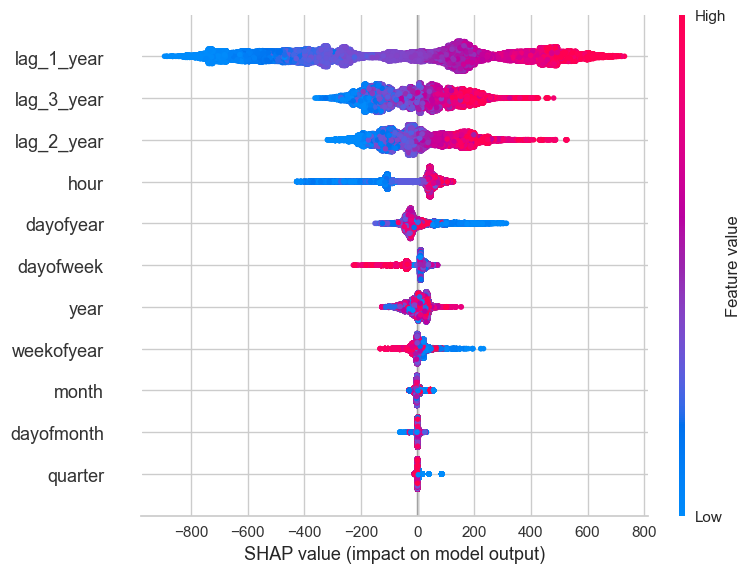

In [23]:
interpret_model(model, plot="summary")

Visualization: The summary plot generated by interpret_model() with SHAP values typically includes a feature importance bar chart. This chart visualizes the magnitude and direction of feature contributions for a specific prediction or across multiple predictions

Blue (Low) Negative SHAP Values: The blue portion of the feature's SHAP values suggests that, in some cases, lower values of this feature have a negative impact on the model's predictions. In other words, when this feature is at its lower end, it tends to push the model's predictions downward (lower than the expected or average prediction).

Pink (High) Values Close to 0: The pink portion of the SHAP values, close to 0, indicates that the feature's values in this range don't significantly influence the model's predictions. The feature's values in this range have a relatively neutral impact.

Positive SHAP Values: The positive SHAP values indicate that higher values of this feature tend to have a positive impact on the model's predictions. When this feature takes on higher values, it pushes the model's predictions upward (higher than the expected or average prediction)

#  Setup new model

Setting up a new model with outliers removal and ready for CV hyperparameter tuning:

In [24]:
modeling_setup_params = {
    "data": training_data,
    "target": target,
    "remove_outliers": True, #added
    "outliers_threshold": 0.01, #added
    "train_size": 0.7,
    "numeric_features": features,
    "imputation_type": "simple",
    "numeric_imputation": "median",
    "normalize": True,
    "normalize_method": "zscore",
    "polynomial_features": True, #added
    "data_split_shuffle": False,
    "fold_strategy": fold_strategy,
    "fold": 5,
    "fold_shuffle": False,
    "log_experiment": False,
    "log_plots": True,
    "session_id": 420
}

modeling_setup = setup(
    **modeling_setup_params
)

,Description,Value
0,Session id,420
1,Target,PJMW_MW
2,Target type,Regression
3,Original data shape,"(143206, 12)"
4,Transformed data shape,"(142203, 78)"
5,Transformed train set shape,"(99241, 78)"
6,Transformed test set shape,"(42962, 78)"
7,Numeric features,11
8,Rows with missing values,18.3%
9,Preprocess,True


In [25]:
starting_params = {
    'n_estimators': 5,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}
reg = xgb.XGBRegressor(**starting_params)
model = create_model(reg)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:55:36
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,425.3804,333030.5625,577.0880,0.5885,0.0932,0.0693
1,573.1365,463801.9688,681.0301,0.4838,0.1247,0.1093
2,463.4716,320615.6250,566.2293,0.6494,0.1041,0.0888
3,447.6033,367120.5625,605.9047,0.6393,0.1023,0.0767
4,446.7135,320138.9375,565.8082,0.6304,0.1028,0.0838
Mean,471.2611,360941.5312,599.2121,0.5983,0.1054,0.0856
Std,52.3576,54200.5583,43.4330,0.0609,0.0104,0.0136


The performance of the model created on the hold-out set:

In [26]:
predict_model(model)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1_year,lag_2_year,lag_3_year,PJMW_MW,prediction_label
100244,21,5,3,9,2013,250,7,36,5077.0,5525.0,5006.0,5357.0,5301.670410
100245,22,5,3,9,2013,250,7,36,4850.0,5247.0,4789.0,5132.0,5061.072266
100246,23,5,3,9,2013,250,7,36,4577.0,4884.0,4492.0,4769.0,4797.822754
100247,0,6,3,9,2013,251,8,36,4218.0,4515.0,4166.0,4406.0,4616.545898
100248,1,6,3,9,2013,251,8,36,3882.0,4250.0,3906.0,4078.0,4355.696777
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143201,20,3,3,8,2018,214,2,31,7175.0,6987.0,5584.0,6545.0,6225.517090
143202,21,3,3,8,2018,214,2,31,6957.0,6802.0,5637.0,6496.0,6225.517090
143203,22,3,3,8,2018,214,2,31,6770.0,6660.0,5513.0,6325.0,6225.517090
143204,23,3,3,8,2018,214,2,31,6207.0,6162.0,5164.0,5892.0,6003.231934


# Tune Model

Assume that the trained model is promising. The next thing that can be done is to tune it.
<br>
There are many methods available [here](https://pycaret.readthedocs.io/en/latest/api/regression.html#pycaret.regression.tune_model).
<br>
It turns out that __tune-sklearn__ is a faster way to find optimal hyperparameters and it allows to choose different search algorithms, not just random and grid search.

The trained model from before has the following parameters:

In [27]:
# print the description of the model with all the parameters
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

"estimator": This parameter specifies the machine learning regression model that you want to tune. It's the base model that PyCaret will optimize using hyperparameter tuning.

"n_iter": It defines the number of iterations or search rounds to perform during the hyperparameter tuning process. More iterations can potentially lead to better-tuned models but may require more computation time.

"early_stopping": When set to True, this parameter enables early stopping during the hyperparameter tuning process. Early stopping allows the tuning process to stop if it determines that further iterations are unlikely to significantly improve model performance. It can help save time and resources.

"optimize": This parameter specifies the optimization criterion or metric to be used during hyperparameter tuning. In this case, "RMSE" stands for Root Mean Squared Error, which is a common metric for regression tasks. The tuning process aims to minimize RMSE to find the best-performing model.

"search_library": It defines the library or framework used for hyperparameter tuning. In this case, "tune-sklearn" indicates the use of the Tune-sklearn library, which is an extension of Ray Tune for hyperparameter tuning in scikit-learn models.

"search_algorithm": This parameter specifies the search algorithm to be used for hyperparameter optimization. "hyperopt" is one of the search algorithms available in Tune-sklearn. It's responsible for intelligently searching the hyperparameter space to find optimal values.

"return_train_score": When set to True, this parameter indicates that the tuning process should also compute and return the training scores (performance metrics) for each set of hyperparameters. This information can be helpful for assessing overfitting during tuning.

In [ ]:
# #downgrade the problematic package
# %pip install ray==2.6.3

In [ ]:
# this takes a lot of time to run, approx 30 mins for 2 iterations

tuned_model_params = {
    "estimator": model,
    "n_iter": 2,
    "early_stopping": True,
    "optimize": "RMSE",
    "search_library": "tune-sklearn",
    "search_algorithm": "hyperopt",
    "return_train_score": True
}
tuned_model = tune_model(**tuned_model_params)

Now we can check the tuned model performance on the hold-out set

In [ ]:
holdout_predictions = predict_model(tuned_model)
holdout_predictions

Let's have a look at the tuned model performance. To choose a different score to plot, refer to [link](https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html).

In [ ]:
evaluate_model(tuned_model, plot_kwargs={"scoring": "neg_root_mean_squared_error"})

We can already see from the pipeline plot that the steps are more and more complex

Let's check Feature Importance


In [ ]:
interpret_model(tuned_model)

# Finalize model

Assuming that the tuned model is satisfactory, we finalize the model by retraining on the full training dataset:

In [30]:
# comment to use tuned model as final
final_model = finalize_model(model)

In [ ]:
# # uncomment to use tuned model as final
# final_model = finalize_model(tuned_model)

Visual representation of the Pipeline with all the details:

In [31]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['hour', 'dayofweek', 'quarter',
                                             'month', 'year', 'dayofyear',
                                             'dayofmonth', 'weekofyear',
                                             'lag_1_year', 'lag_2_year',
                                             'lag_3_year'],
                                    transformer=SimpleImputer(strategy='median'))),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=5, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [32]:
save_model(final_model, "final_model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['hour', 'dayofweek', 'quarter',
                                              'month', 'year', 'dayofyear',
                                              'dayofmonth', 'weekofyear',
                                              'lag_1_year', 'lag_2_year',
                                              'lag_3_year'],
                                     transformer=SimpleImputer(strategy='median'))),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                        

# Load model and create forecasts

### Create forecast dataframe with dates and features

In [33]:
min_forecast_date = fe_data.index.max() # last day of the train dataframe
# forecast horizon 1 year
max_forecast_date = (pd.Timestamp(min_forecast_date.year, min_forecast_date.month, 1) + pd.offsets.DateOffset(years=1)) 

Checking the forecasting dates dates

In [34]:
min_forecast_date, max_forecast_date

(Timestamp('2018-08-03 00:00:00'), Timestamp('2019-08-01 00:00:00'))

Creating Forecast Dataset

In [35]:
# Hourly forecast dataframe 
future_dates = pd.date_range(min_forecast_date, max_forecast_date, freq="H")
future_data = pd.DataFrame(index=future_dates)
# forecast indicator
future_data["is_future"] = True
# train data indicator
fe_data["is_future"] = False

In [36]:
# merge forecast and train dataframes to create the features for the predictions
concat_data = pd.concat([fe_data, future_data], axis=0)
concat_data = extract_dt(concat_data)
concat_data = add_lags(concat_data, target, lags_dict)

In [37]:
# keep the rows where indicator shows forecasting dates
forecast_data = concat_data.loc[concat_data["is_future"]==True]
# drop the target
forecast_data.drop(columns=target, axis=1, inplace=True)

In [38]:
forecast_data

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1_year,lag_2_year,lag_3_year,is_future
2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,5713.0,5620.0,4772.0,True
2018-08-03 01:00:00,1,4,3,8,2018,215,3,31,5260.0,5226.0,4421.0,True
2018-08-03 02:00:00,2,4,3,8,2018,215,3,31,4965.0,4913.0,4184.0,True
2018-08-03 03:00:00,3,4,3,8,2018,215,3,31,4815.0,4677.0,4085.0,True
2018-08-03 04:00:00,4,4,3,8,2018,215,3,31,4620.0,4638.0,4031.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,20,2,3,7,2019,212,31,31,6816.0,7240.0,6951.0,True
2019-07-31 21:00:00,21,2,3,7,2019,212,31,31,6571.0,6970.0,6864.0,True
2019-07-31 22:00:00,22,2,3,7,2019,212,31,31,6362.0,6697.0,6670.0,True
2019-07-31 23:00:00,23,2,3,7,2019,212,31,31,5881.0,6250.0,6162.0,True


## Forecast

In [39]:
# Load model
prod_model = load_model("final_model")

Transformation Pipeline and Model Successfully Loaded


In [40]:
# make predictions
forecasts = predict_model(prod_model, data=forecast_data[features])

In [41]:
forecasts

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1_year,lag_2_year,lag_3_year,prediction_label
2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,5713.0,5620.0,4772.0,5352.844727
2018-08-03 01:00:00,1,4,3,8,2018,215,3,31,5260.0,5226.0,4421.0,5045.462402
2018-08-03 02:00:00,2,4,3,8,2018,215,3,31,4965.0,4913.0,4184.0,4864.890137
2018-08-03 03:00:00,3,4,3,8,2018,215,3,31,4815.0,4677.0,4085.0,4800.392578
2018-08-03 04:00:00,4,4,3,8,2018,215,3,31,4620.0,4638.0,4031.0,4689.037109
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,20,2,3,7,2019,212,31,31,6816.0,7240.0,6951.0,6521.520996
2019-07-31 21:00:00,21,2,3,7,2019,212,31,31,6571.0,6970.0,6864.0,6513.960449
2019-07-31 22:00:00,22,2,3,7,2019,212,31,31,6362.0,6697.0,6670.0,6350.367188
2019-07-31 23:00:00,23,2,3,7,2019,212,31,31,5881.0,6250.0,6162.0,5998.836914


In [42]:
# save the output
forecasts.to_parquet("forecasts.parquet")

### Open question:
In case of using a model in which you can add predictors, what kind of external data could be used to improve the predictions?